In [1]:
import csv
import json
import numpy as np
import pickle
import re
import sys
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def is_kernel():
    if 'IPython' not in sys.modules:
        return False
    from IPython import get_ipython
    return getattr(get_ipython(), 'kernel', None) is not None

In [10]:
if not is_kernel():
    if len(sys.argv) <= 1:
        print("Need to specify input size.")
        sys.exit()
    INPUT_SIZE = sys.argv[1]
else:
    INPUT_SIZE = "Small"

**Load previously saved data.**

In [11]:
with open("log/index_to_county.pickle", "rb") as picklefile:
    index_to_county = pickle.load(picklefile)

In [12]:
with open("log/dates.pickle", "rb") as picklefile:
    dates = pickle.load(picklefile)

In [13]:
with open("log/index_to_region.pickle", "rb") as picklefile:
    index_to_region = pickle.load(picklefile)

#### Parse out the county-level flu rates.

In [14]:
OUTPUT_FILE = "out/output_%s.txt" % INPUT_SIZE.lower()

In [15]:
pos_pattern = r"query : y\(County\[(\d+)\], Week\[(\d+)\]\)\n{2}Mean = (\d+\.\d+)\s"
neg_pattern = r"query : y\(County\[(\d+)\], Week\[(\d+)\]\)\n{2}Mean = -(\d+\.\d+)\s"

with open(OUTPUT_FILE, "r") as output_file:
    pos_searches = re.findall(pos_pattern, output_file.read())
    output_file.seek(0)
    neg_searches = re.findall(neg_pattern, output_file.read())

In [16]:
correlations = {}
for q in pos_searches:
    correlations[int(q[0]), int(q[1])] = 1.0 * float(q[2])
for q in neg_searches:
    correlations[int(q[0]), int(q[1])] = -1.0 * float(q[2])

In [17]:
corr_matrix = np.zeros((len(index_to_county), len(dates)))

In [18]:
# for i in range(len(dates)):
#   for j in range(len(index_to_county)):
#     corr_matrix[j][i] = correlations[(j,i)]

In [19]:
corr_matrix.shape

(82, 103)

In [20]:
pos_pattern = r"query : logit\(County\[(\d+)\], Week\[(\d+)\]\)\n{2}Mean = (\d+\.\d+)\s"
neg_pattern = r"query : logit\(County\[(\d+)\], Week\[(\d+)\]\)\n{2}Mean = -(\d+\.\d+)\s"

with open(OUTPUT_FILE, "r") as output_file:
    pos_searches = re.findall(pos_pattern, output_file.read())
    output_file.seek(0)
    neg_searches = re.findall(neg_pattern, output_file.read())

In [21]:
predictions = {}
for q in pos_searches:
    predictions[int(q[0]), int(q[1])] = 1.0 * float(q[2])
for q in neg_searches:
    predictions[int(q[0]), int(q[1])] = -1.0 * float(q[2])

In [22]:
for k, v in predictions.items():
  v = 1.0 / (1.0 + np.exp(-1.0 * v))
  predictions[k] = v

#### Write output JSON.

In [23]:
output_dict = {}

In [24]:
for (i, fips) in index_to_county.items():
    county_dict = {
        "ILI percentage %": {}
    }
    for j, t in enumerate(dates):
        county_dict["ILI percentage %"][t] = predictions[(i,j)] * 100.0
    output_dict[fips] = county_dict

In [25]:
with open("out/%s/CountyWeeklyILI.json" % INPUT_SIZE, "w") as jsonfile:
    jsonfile.write(json.dumps(output_dict))

#### Evaluate

In [26]:
eval_data = []

In [27]:
with open("data/%s/eval/Flu_ILI_TRUTH.csv" % INPUT_SIZE, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        eval_data.append(row)

In [28]:
county_map_matrix = np.loadtxt("./data_processed/county_map.txt")
region_pop_matrix = np.loadtxt("./data_processed/region_pops.txt")

In [29]:
print(county_map_matrix.shape)
print(region_pop_matrix.shape)

(9, 82)
(9,)


**Graphs**

In [37]:
history = []
county_level_history = []

In [38]:
loss = 0.0

In [39]:
for t, date in enumerate(dates):
    county_vector = np.array([predictions[(i, t)] for i in range(len(index_to_county))])
    region_rates = np.dot(county_map_matrix, county_vector)
    region_rates = region_rates / region_pop_matrix
    history.append(region_rates)
    county_level_history.append(county_vector)
    for i, predicted_rate in enumerate(region_rates):
        if eval_data[t][index_to_region[i]] != 'NaN':
            loss += region_pop_matrix[i] * (predicted_rate * 100 - float(eval_data[t][index_to_region[i]][0:-1]))**2

In [40]:
history = np.array(history).T
county_level_history = np.array(county_level_history).T

In [41]:
print("Total loss:", loss)

Total loss: 7995546826.41


In [42]:
print("MSE:", loss / np.sum(region_pop_matrix) / np.sum(len(dates)))

MSE: 25.926726789


In [43]:
print("RMSE:", (loss / np.sum(region_pop_matrix) / np.sum(len(dates)))**0.5)

RMSE: 5.09182941475


In [44]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

In [45]:
logit = lambda y: -1 * np.log((1 - y) / y)

In [46]:
obs = np.loadtxt("data_processed/obs.txt").T

In [47]:
logit(county_level_history[0][20]) == logit(predictions[(0,20)])

True

In [52]:
# % matplotlib inline

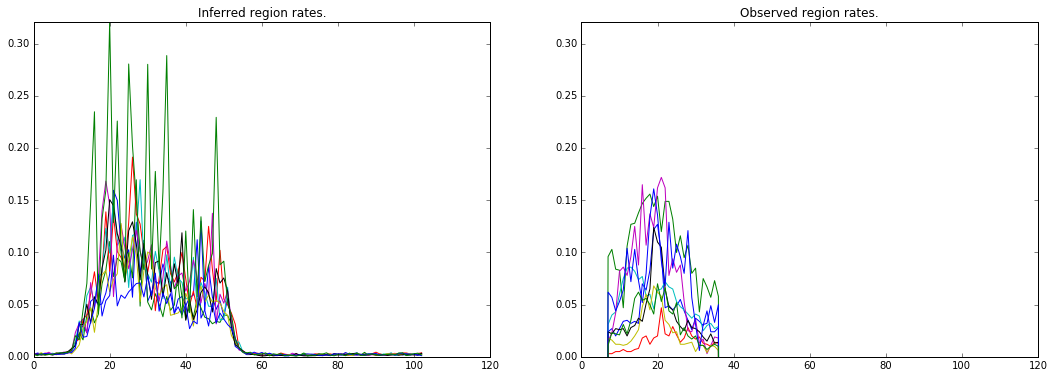

In [53]:
plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.plot(np.array(history)[:,:].T)
plt.ylim([0, np.max(history)])
plt.title("Inferred region rates.")
plt.subplot(1,2,2)
plt.plot(obs[:,:].T)
plt.ylim([0, np.max(history)])
plt.title("Observed region rates.")
plt.savefig("out/%s/region_rates.png" % INPUT_SIZE)

In [61]:
ind = np.random.randint(0, len(index_to_county))

In [62]:
priors = np.loadtxt("data_processed/priors.txt")

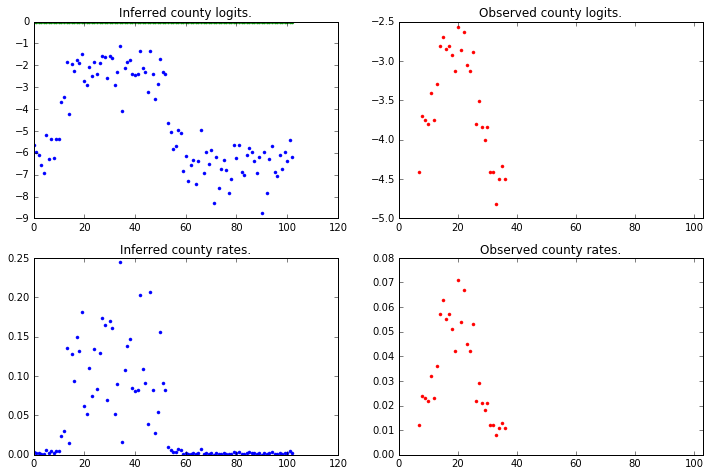

In [63]:
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.plot(corr_matrix[ind,:], '.g')
plt.plot(logit(np.array(county_level_history)[ind,:]), '.b')
plt.title("Inferred county logits.")
plt.subplot(3,2,2)
plt.plot(priors[ind,:], '.r')
plt.xlim([0, 103])
plt.title("Observed county logits.")
plt.subplot(3,2,3)
plt.plot(np.array(county_level_history)[ind,:], '.b')
plt.title("Inferred county rates.")
plt.subplot(3,2,4)
plt.plot(sigmoid(priors[ind,:]), '.r')
plt.xlim([0, 103])
plt.title("Observed county rates.")
plt.savefig("out/%s/county_rates.png" % INPUT_SIZE)